# Notebook 2: Generate Residence Centroids, determine `d1` and visualize centroids and nearest OSMNx nodes

## Introduction to Notebook 2

Our goal within the next three notebooks is to derive the values of three distances from the:
1. `d1` - distance between a Parish residence centroid and the closest OSMNx node
2. `d2` - distance between a testing facility and the closest OSMNx node
3. `d3` - the shortest distance (and route) between the OSMNx nodes (parish residence and testing facility)

<img src="images/d1-d2-d3.jpeg" alt="d1-d2-d3 image" width="700"/>

## Data sources for this notebook

### Data Source: GADM

Download page: https://gadm.org/download_country_v3.html  Use GeoPackage link.

What is GeoPackage? https://www.geopackage.org/

### Download Uganda geopackage

In [1]:
import os

In [2]:
if not os.path.exists('data/gadm36_UGA.gpkg'):
    if not os.path.exists('data/gadm_gpkg.zip'):
        os.system('wget https://biogeo.ucdavis.edu/data/gadm3.6/gpkg/gadm36_UGA_gpkg.zip -O data/gadm_gpkg.zip')
    os.system('unzip data/gadm_gpkg.zip -d data')

### Load Uganda GeoPackage as a GeoPandas GeoDataFrame (GDF)

What is GeoPandas? https://geopandas.org/

What is the difference between Pandas and GeoPandas?

What is GADM? https://gadm.org/

In [3]:
import geopandas as gpd

uganda_gdf = gpd.read_file('data/gadm36_UGA.gpkg')

In [4]:
uganda_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5341 entries, 0 to 5340
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_0      5341 non-null   object  
 1   NAME_0     5341 non-null   object  
 2   GID_1      5341 non-null   object  
 3   NAME_1     5341 non-null   object  
 4   GID_2      5341 non-null   object  
 5   NAME_2     5341 non-null   object  
 6   GID_3      5341 non-null   object  
 7   NAME_3     5341 non-null   object  
 8   GID_4      5341 non-null   object  
 9   NAME_4     5341 non-null   object  
 10  VARNAME_4  0 non-null      object  
 11  TYPE_4     5341 non-null   object  
 12  ENGTYPE_4  5341 non-null   object  
 13  CC_4       0 non-null      object  
 14  geometry   5341 non-null   geometry
dtypes: geometry(1), object(14)
memory usage: 626.0+ KB


<AxesSubplot:>

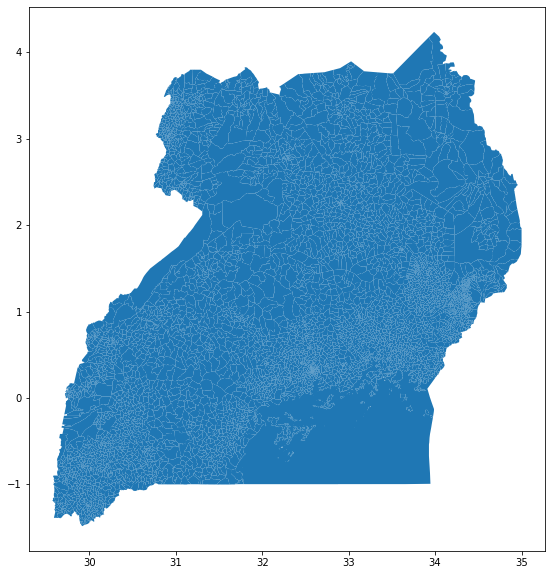

In [5]:
uganda_gdf.plot(figsize=(20, 10))

### Create bounding parish polygon

In this section we will create the bounding parish polygon to enable us to create the data set that includes OSM building footprints for that parish. Downloading all building footprints for all parishes would consume a lot of resources (RAM) - for this initial exploration we will focus on one parish.

A few parishes to select from:

1. Karubi
2. Kisugu

How many parishes are there in Kampala?

In [6]:
parish_gdf = uganda_gdf[uganda_gdf['NAME_4']=='Kisugu'].copy()

In [7]:
parish_polygon = parish_gdf['geometry'].unary_union

In [8]:
type(parish_polygon)

shapely.geometry.polygon.Polygon

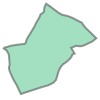

In [9]:
parish_polygon

In [10]:
parish_json = gpd.GeoSeries([parish_polygon]).__geo_interface__

In [11]:
parish_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

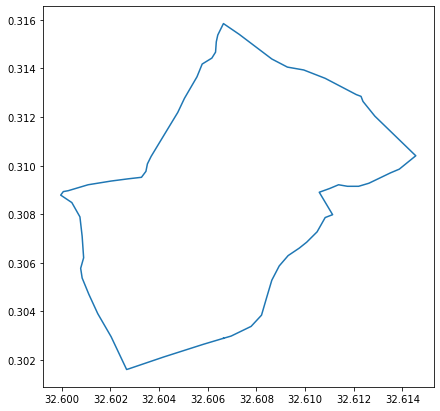

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)

x,y = parish_polygon.exterior.xy
plt.plot(x,y)

## Process OSMNx building footprints

### Set up OSMNx and Overpass API

What is OSMNx?

What is the Overpass API?

In [13]:
import osmnx as ox, csv

with open('overpass-api.csv', mode='r') as infile:
    reader = csv.reader(infile)
    overpass_api = {rows[0]:rows[1] for rows in reader}

ox.config(
    log_console=True, 
    use_cache=True, 
    log_file=True,
    overpass_endpoint=overpass_api['main']
)

### OSMNx building footprints in GeoPandas GeoDataFrame

Reference: https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.geometries.geometries_from_polygon

In [14]:
buildings_gdf = ox.geometries.geometries_from_polygon(parish_polygon, tags={'building':True})

In [15]:
buildings_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 3530 entries, ('way', 135032697) to ('way', 945460226)
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   amenity           5 non-null      object  
 1   geometry          3530 non-null   geometry
 2   name              21 non-null     object  
 3   nodes             3530 non-null   object  
 4   building          3530 non-null   object  
 5   religion          3 non-null      object  
 6   alt_name          1 non-null      object  
 7   denomination      1 non-null      object  
 8   source            14 non-null     object  
 9   addr:city         2 non-null      object  
 10  addr:street       2 non-null      object  
 11  addr:country      1 non-null      object  
 12  addr:housenumber  1 non-null      object  
 13  addr:suburb       1 non-null      object  
dtypes: geometry(1), object(13)
memory usage: 553.3+ KB


### Using GeoPandas `explore()` (Folium Map)

Reference: https://geopandas.org/docs/user_guide/interactive_mapping.html

In [16]:
buildings_gdf.explore()

### Select GeoDataFrame columns

In [17]:
filtered_buildings_gdf = buildings_gdf[['building','geometry']].copy()

In [18]:
filtered_buildings_gdf['building'].unique()

array(['yes', 'school', 'residential', 'dormitory', 'duplex',
       'Adult education', 'r', 'roof', 'apartments', 'house', 'ruins',
       'Bar', 'retail', 'church', 'clinic', 'supermarket', 'terrace',
       'commercial'], dtype=object)

In [19]:
include_list = ['residential', 'dormitory', 'duplex', 'apartments', 'house']

In [20]:
%%time
residential_gdf = filtered_buildings_gdf[filtered_buildings_gdf['building'].isin(include_list)].copy()

residential_gdf

CPU times: user 5.76 ms, sys: 0 ns, total: 5.76 ms
Wall time: 5.79 ms


building  \
element_type osmid                    
way          140823106  residential   
             140823115    dormitory   
             140826566       duplex   
             140826574  residential   
             142109314  residential   
...                             ...   
             566748730        house   
             566748732        house   
             566748733        house   
             569163822        house   
             569165907        house   

                                                                 geometry  
element_type osmid                                                         
way          140823106  POLYGON ((32.60823 0.30510, 32.60830 0.30505, ...  
             140823115  POLYGON ((32.60815 0.30537, 32.60823 0.30544, ...  
             140826566  POLYGON ((32.60842 0.30460, 32.60853 0.30465, ...  
             140826574  POLYGON ((32.60832 0.30456, 32.60836 0.30459, ...  
             142109314  POLYGON ((32.60797 0.30467, 32.60804 0.30473, ...  
...                                                                   ...  
             566748730  POLYGON ((32.60824 0.30877, 32.60830 0.30871, ...  
             566748732  POLYGON ((32.60817 0.30888, 32.60823 0.30879, ...  
             566748733  POLYGON ((32.60799 0.30873, 32.60800 0.30872, ...  
             569163822  POLYGON ((32.60812 0.30913, 32.60815 0.30905, ...  
             569165907  POLYGON ((32.60874 0.31013, 32.60881 0.31018, ...  

[213 rows x 2 columns]

In [21]:
residential_gdf.explore()

In [22]:
residential_gdf.reset_index(inplace=True)

residential_gdf

element_type      osmid     building  \
0            way  140823106  residential   
1            way  140823115    dormitory   
2            way  140826566       duplex   
3            way  140826574  residential   
4            way  142109314  residential   
..           ...        ...          ...   
208          way  566748730        house   
209          way  566748732        house   
210          way  566748733        house   
211          way  569163822        house   
212          way  569165907        house   

                                              geometry  
0    POLYGON ((32.60823 0.30510, 32.60830 0.30505, ...  
1    POLYGON ((32.60815 0.30537, 32.60823 0.30544, ...  
2    POLYGON ((32.60842 0.30460, 32.60853 0.30465, ...  
3    POLYGON ((32.60832 0.30456, 32.60836 0.30459, ...  
4    POLYGON ((32.60797 0.30467, 32.60804 0.30473, ...  
..                                                 ...  
208  POLYGON ((32.60824 0.30877, 32.60830 0.30871, ...  
209  POLYGON ((32.60817 0.30888, 32.60823 0.30879, ...  
210  POLYGON ((32.60799 0.30873, 32.60800 0.30872, ...  
211  POLYGON ((32.60812 0.30913, 32.60815 0.30905, ...  
212  POLYGON ((32.60874 0.31013, 32.60881 0.31018, ...  

[213 rows x 4 columns]

### Set CRS to EPSG:4326

Why is it important to set a CRS for a GeoDataFrame (GDF)?

In [23]:
residential_gdf.to_crs('EPSG:4326')

element_type      osmid     building  \
0            way  140823106  residential   
1            way  140823115    dormitory   
2            way  140826566       duplex   
3            way  140826574  residential   
4            way  142109314  residential   
..           ...        ...          ...   
208          way  566748730        house   
209          way  566748732        house   
210          way  566748733        house   
211          way  569163822        house   
212          way  569165907        house   

                                              geometry  
0    POLYGON ((32.60823 0.30510, 32.60830 0.30505, ...  
1    POLYGON ((32.60815 0.30537, 32.60823 0.30544, ...  
2    POLYGON ((32.60842 0.30460, 32.60853 0.30465, ...  
3    POLYGON ((32.60832 0.30456, 32.60836 0.30459, ...  
4    POLYGON ((32.60797 0.30467, 32.60804 0.30473, ...  
..                                                 ...  
208  POLYGON ((32.60824 0.30877, 32.60830 0.30871, ...  
209  POLYGON ((32.60817 0.30888, 32.60823 0.30879, ...  
210  POLYGON ((32.60799 0.30873, 32.60800 0.30872, ...  
211  POLYGON ((32.60812 0.30913, 32.60815 0.30905, ...  
212  POLYGON ((32.60874 0.31013, 32.60881 0.31018, ...  

[213 rows x 4 columns]

### Obtain Residence Centroids

What is a centroid? 

In [24]:
residential_centroids_gdf = residential_gdf.copy()

In [25]:
residential_centroids_gdf['geometry'] = residential_centroids_gdf['geometry'].centroid

residential_centroids_gdf

/tmp/ipykernel_9738/1830439308.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  residential_centroids_gdf['geometry'] = residential_centroids_gdf['geometry'].centroid


element_type      osmid     building                  geometry
0            way  140823106  residential  POINT (32.60825 0.30505)
1            way  140823115    dormitory  POINT (32.60825 0.30534)
2            way  140826566       duplex  POINT (32.60850 0.30457)
3            way  140826574  residential  POINT (32.60836 0.30454)
4            way  142109314  residential  POINT (32.60802 0.30468)
..           ...        ...          ...                       ...
208          way  566748730        house  POINT (32.60822 0.30869)
209          way  566748732        house  POINT (32.60816 0.30881)
210          way  566748733        house  POINT (32.60805 0.30873)
211          way  569163822        house  POINT (32.60818 0.30910)
212          way  569165907        house  POINT (32.60879 0.31013)

[213 rows x 4 columns]

In [26]:
residential_centroids_gdf['lat'] = residential_centroids_gdf.centroid.y
residential_centroids_gdf['lon'] = residential_centroids_gdf.centroid.x

residential_centroids_gdf

/tmp/ipykernel_9738/3520687935.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  residential_centroids_gdf['lat'] = residential_centroids_gdf.centroid.y
/tmp/ipykernel_9738/3520687935.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  residential_centroids_gdf['lon'] = residential_centroids_gdf.centroid.x


element_type      osmid     building                  geometry       lat  \
0            way  140823106  residential  POINT (32.60825 0.30505)  0.305050   
1            way  140823115    dormitory  POINT (32.60825 0.30534)  0.305341   
2            way  140826566       duplex  POINT (32.60850 0.30457)  0.304566   
3            way  140826574  residential  POINT (32.60836 0.30454)  0.304541   
4            way  142109314  residential  POINT (32.60802 0.30468)  0.304678   
..           ...        ...          ...                       ...       ...   
208          way  566748730        house  POINT (32.60822 0.30869)  0.308691   
209          way  566748732        house  POINT (32.60816 0.30881)  0.308810   
210          way  566748733        house  POINT (32.60805 0.30873)  0.308729   
211          way  569163822        house  POINT (32.60818 0.30910)  0.309100   
212          way  569165907        house  POINT (32.60879 0.31013)  0.310129   

           lon  
0    32.608250  
1    32.608246  
2    32.608496  
3    32.608361  
4    32.608019  
..         ...  
208  32.608221  
209  32.608156  
210  32.608050  
211  32.608182  
212  32.608791  

[213 rows x 6 columns]

In [27]:
residential_centroids_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Create analysis columns

### Create projected lat/lon columns

In [28]:
import yaml

with open("proj_crs.yml", "r") as stream:
    try:
        epsg_dict = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
proj_epsg_str = str(epsg_dict).replace("{","").replace("}", "").replace("'","").replace(" ","")

print('Projected graph EPSG code:',proj_epsg_str)

Projected graph EPSG code: EPSG:32636


Reference for 32636: https://epsg.io/32636

In [29]:
residential_centroids_proj_gdf = residential_centroids_gdf.to_crs(proj_epsg_str)

residential_centroids_proj_gdf.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
residential_centroids_proj_gdf

element_type      osmid     building                      geometry  \
0            way  140823106  residential  POINT (456408.254 33718.007)   
1            way  140823115    dormitory  POINT (456407.820 33750.206)   
2            way  140826566       duplex  POINT (456435.687 33664.535)   
3            way  140826574  residential  POINT (456420.616 33661.704)   
4            way  142109314  residential  POINT (456382.566 33676.918)   
..           ...        ...          ...                           ...   
208          way  566748730        house  POINT (456405.109 34120.398)   
209          way  566748732        house  POINT (456397.916 34133.590)   
210          way  566748733        house  POINT (456386.082 34124.648)   
211          way  569163822        house  POINT (456400.786 34165.603)   
212          way  569165907        house  POINT (456468.520 34279.401)   

          lat        lon  
0    0.305050  32.608250  
1    0.305341  32.608246  
2    0.304566  32.608496  
3    0.304541  32.608361  
4    0.304678  32.608019  
..        ...        ...  
208  0.308691  32.608221  
209  0.308810  32.608156  
210  0.308729  32.608050  
211  0.309100  32.608182  
212  0.310129  32.608791  

[213 rows x 6 columns]

In [31]:
residential_centroids_proj_gdf['prj_lat'] = residential_centroids_proj_gdf.geometry.y
residential_centroids_proj_gdf['prj_lon'] = residential_centroids_proj_gdf.geometry.x

In [32]:
residential_centroids_proj_gdf

element_type      osmid     building                      geometry  \
0            way  140823106  residential  POINT (456408.254 33718.007)   
1            way  140823115    dormitory  POINT (456407.820 33750.206)   
2            way  140826566       duplex  POINT (456435.687 33664.535)   
3            way  140826574  residential  POINT (456420.616 33661.704)   
4            way  142109314  residential  POINT (456382.566 33676.918)   
..           ...        ...          ...                           ...   
208          way  566748730        house  POINT (456405.109 34120.398)   
209          way  566748732        house  POINT (456397.916 34133.590)   
210          way  566748733        house  POINT (456386.082 34124.648)   
211          way  569163822        house  POINT (456400.786 34165.603)   
212          way  569165907        house  POINT (456468.520 34279.401)   

          lat        lon       prj_lat        prj_lon  
0    0.305050  32.608250  33718.007459  456408.254358  
1    0.305341  32.608246  33750.205740  456407.820296  
2    0.304566  32.608496  33664.534735  456435.687482  
3    0.304541  32.608361  33661.703514  456420.615673  
4    0.304678  32.608019  33676.917935  456382.566259  
..        ...        ...           ...            ...  
208  0.308691  32.608221  34120.397882  456405.108903  
209  0.308810  32.608156  34133.589753  456397.915561  
210  0.308729  32.608050  34124.647515  456386.082123  
211  0.309100  32.608182  34165.603267  456400.786301  
212  0.310129  32.608791  34279.400504  456468.520402  

[213 rows x 8 columns]

In [33]:
residential_centroids_4326_gdf = residential_centroids_proj_gdf.to_crs('EPSG:4326')

residential_centroids_4326_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
residential_centroids_4326_gdf

element_type      osmid     building                  geometry       lat  \
0            way  140823106  residential  POINT (32.60825 0.30505)  0.305050   
1            way  140823115    dormitory  POINT (32.60825 0.30534)  0.305341   
2            way  140826566       duplex  POINT (32.60850 0.30457)  0.304566   
3            way  140826574  residential  POINT (32.60836 0.30454)  0.304541   
4            way  142109314  residential  POINT (32.60802 0.30468)  0.304678   
..           ...        ...          ...                       ...       ...   
208          way  566748730        house  POINT (32.60822 0.30869)  0.308691   
209          way  566748732        house  POINT (32.60816 0.30881)  0.308810   
210          way  566748733        house  POINT (32.60805 0.30873)  0.308729   
211          way  569163822        house  POINT (32.60818 0.30910)  0.309100   
212          way  569165907        house  POINT (32.60879 0.31013)  0.310129   

           lon       prj_lat        prj_lon  
0    32.608250  33718.007459  456408.254358  
1    32.608246  33750.205740  456407.820296  
2    32.608496  33664.534735  456435.687482  
3    32.608361  33661.703514  456420.615673  
4    32.608019  33676.917935  456382.566259  
..         ...           ...            ...  
208  32.608221  34120.397882  456405.108903  
209  32.608156  34133.589753  456397.915561  
210  32.608050  34124.647515  456386.082123  
211  32.608182  34165.603267  456400.786301  
212  32.608791  34279.400504  456468.520402  

[213 rows x 8 columns]

In [35]:
%%time
G_proj = ox.load_graphml('data/g_projected.graphml')

CPU times: user 1min 20s, sys: 43 s, total: 2min 3s
Wall time: 2min 3s


### Compute d1 and euclidean distance between origin point for residence centroid and OSMNx node

References:
1. OSMNx Distance - Nearest Nodes: https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes
2. OSMNx Distance - Vectorized Euclidean Distance: https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.euclidean_dist_vec
2. tqdm: https://github.com/tqdm/tqdm

In [36]:
%%time

from tqdm import tqdm, notebook

residential_centroids_4326_gdf['r_node'] = 0
residential_centroids_4326_gdf['r_node_lat'] = 0.0
residential_centroids_4326_gdf['r_node_lon'] = 0.0
residential_centroids_4326_gdf['r_node_y'] = 0.0
residential_centroids_4326_gdf['r_node_x'] = 0.0
residential_centroids_4326_gdf['d1'] = 0.0
residential_centroids_4326_gdf['d1_euc'] = 0.0

# tqdm parameters
total_rows=residential_centroids_4326_gdf.shape[0]

for index, r_row in tqdm(residential_centroids_4326_gdf.iterrows(), total=total_rows):
    r_node, d1 = ox.distance.nearest_nodes(G_proj, r_row['prj_lon'], r_row['prj_lat'], return_dist=True)
    r_node_y = G_proj.nodes[r_node]['y']
    r_node_x = G_proj.nodes[r_node]['x']
    r_node_lat = G_proj.nodes[r_node]['lat']
    r_node_lon = G_proj.nodes[r_node]['lon']
    d1_euc = ox.distance.euclidean_dist_vec(r_row['prj_lat'], r_row['prj_lon'], r_node_y, r_node_x)
    residential_centroids_4326_gdf.loc[index, 'r_node'] = r_node
    residential_centroids_4326_gdf.loc[index, 'r_node_lat'] = r_node_lat
    residential_centroids_4326_gdf.loc[index, 'r_node_lon'] = r_node_lon
    residential_centroids_4326_gdf.loc[index, 'r_node_y'] = r_node_y
    residential_centroids_4326_gdf.loc[index, 'r_node_x'] = r_node_x
    residential_centroids_4326_gdf.loc[index, 'd1'] = d1
    residential_centroids_4326_gdf.loc[index, 'd1_euc'] = d1_euc

    r_dict = {'r_lat':r_row['lat'], 'r_lon':r_row['lon'], 'r_node':r_node, \
              'r_node_lat':r_node_lat, 'r_node_lon':r_node_lon, \
              'r_node_y':r_node_y, 'r_node_x':r_node_x, 'd1':d1, 'd1_euc': d1_euc}
    
    #print(r_dict)

 57%|█████▋    | 121/213 [04:22<03:24,  2.22s/it]

2021-10-17 20:36:46 Configured OSMnx 1.1.1
2021-10-17 20:36:46 HTTP response caching is on
2021-10-17 20:36:47 Projected GeoDataFrame to +proj=utm +zone=36 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2021-10-17 20:36:47 Projected GeoDataFrame to epsg:4326
2021-10-17 20:36:47 Requesting data within polygon from API in 1 request(s)
2021-10-17 20:36:47 Retrieved response from cache file "cache/1d7c048eee6cc50917ef90590f6c0e2e5a77220f.json"
2021-10-17 20:36:47 Got all geometries data within polygon from API in 1 request(s)
2021-10-17 20:36:47 Converting 19420 elements in JSON responses to geometries
2021-10-17 20:36:47 3532 geometries created in the dict
2021-10-17 20:36:47 0 untagged geometries removed
2021-10-17 20:36:48 Created r-tree spatial index for 3532 geometries
2021-10-17 20:36:48 Identified 3532 geometries inside polygon
2021-10-17 20:36:48 0 geometries removed by the polygon filter
2021-10-17 20:36:48 2 geometries removed by the tag filter
2021-10-17 20:36:48 3530 geo

100%|██████████| 213/213 [07:50<00:00,  2.21s/it]

CPU times: user 7min 54s, sys: 0 ns, total: 7min 54s
Wall time: 7min 50s


In [37]:
residential_centroids_4326_gdf['r_node'] = residential_centroids_4326_gdf['r_node'].astype(int)

residential_centroids_4326_gdf

element_type      osmid     building                  geometry       lat  \
0            way  140823106  residential  POINT (32.60825 0.30505)  0.305050   
1            way  140823115    dormitory  POINT (32.60825 0.30534)  0.305341   
2            way  140826566       duplex  POINT (32.60850 0.30457)  0.304566   
3            way  140826574  residential  POINT (32.60836 0.30454)  0.304541   
4            way  142109314  residential  POINT (32.60802 0.30468)  0.304678   
..           ...        ...          ...                       ...       ...   
208          way  566748730        house  POINT (32.60822 0.30869)  0.308691   
209          way  566748732        house  POINT (32.60816 0.30881)  0.308810   
210          way  566748733        house  POINT (32.60805 0.30873)  0.308729   
211          way  569163822        house  POINT (32.60818 0.30910)  0.309100   
212          way  569165907        house  POINT (32.60879 0.31013)  0.310129   

           lon       prj_lat        prj_lon      r_node  r_node_lat  \
0    32.608250  33718.007459  456408.254358  6227266298    0.304598   
1    32.608246  33750.205740  456407.820296   579993314    0.305541   
2    32.608496  33664.534735  456435.687482  6227266298    0.304598   
3    32.608361  33661.703514  456420.615673  6227266298    0.304598   
4    32.608019  33676.917935  456382.566259  6227266299    0.304586   
..         ...           ...            ...         ...         ...   
208  32.608221  34120.397882  456405.108903   579993370    0.308425   
209  32.608156  34133.589753  456397.915561  1460122475    0.309157   
210  32.608050  34124.647515  456386.082123   579993372    0.308345   
211  32.608182  34165.603267  456400.786301  6226990677    0.309216   
212  32.608791  34279.400504  456468.520402   579993409    0.310385   

     r_node_lon      r_node_y       r_node_x         d1     d1_euc  
0     32.608301  33668.059384  456413.978289  50.274980  50.274980  
1     32.608458  33772.268954  456431.508054  32.371211  32.371211  
2     32.608301  33668.059384  456413.978289  21.993458  21.993458  
3     32.608301  33668.059384  456413.978289   9.189774   9.189774  
4     32.608271  33666.644688  456410.617702  29.873451  29.873451  
..          ...           ...            ...        ...        ...  
208   32.608363  34091.045584  456420.859487  33.311234  33.311234  
209   32.608019  34171.901647  456382.650297  41.241114  41.241114  
210   32.608216  34082.148305  456404.512718  46.323533  46.323533  
211   32.608195  34178.499727  456402.201729  12.973901  12.973901  
212   32.608824  34307.676678  456472.243592  28.520241  28.520241  

[213 rows x 15 columns]

## Map Residence Centroids and OSMNx nodes

What is folium? https://python-visualization.github.io/folium/

In [38]:
import folium
from folium import plugins

map1 = residential_centroids_4326_gdf.explore(
    marker_kwds=dict(radius=5))

# Tile Layer (can add more, these become radio buttons on Layer Control)
folium.TileLayer('cartodbpositron').add_to(map1)

# Feature groups become checkboxes in Layer Control Widget
fg0=folium.FeatureGroup(name='Parish Boundary', show=False)
fg1=folium.FeatureGroup(name='Residences', show=False)
fg2=folium.FeatureGroup(name='Residence Nodes', show=False)
fg3=folium.FeatureGroup(name='Residence to Node', show=False)

# GeoJSON parish boundary with style function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0, 
                            'weight': 3}
folium.GeoJson(
    data=parish_gdf['geometry'], 
    name="geojson",
    style_function=style_function
).add_to(fg0)

# Residences, Nodes and Residence-to-Node Paths
for index,row in residential_centroids_4326_gdf.iterrows():

    folium.CircleMarker(
                    location=[row['lat'],row['lon']], \
                    radius=4, \
                    color='black', \
                    weight=1, \
                    fill=True, \
                    fill_color='red', \
                    fill_opacity=1).add_to(fg1)


    folium.CircleMarker(
                    location=[row['r_node_lat'],row['r_node_lon']], \
                    radius=4, \
                    color='black', \
                    weight=1, \
                    fill=True, \
                    fill_color='yellow', \
                    fill_opacity=1).add_to(fg2)
    
    r_line_points = ((row['lat'],row['lon']),(row['r_node_lat'],row['r_node_lon']))
    folium.PolyLine(r_line_points,
                    color='gray',
                    weight=2,
                    opacity=0.8
                   ).add_to(fg3)

fg0.add_to(map1)
fg1.add_to(map1)
fg2.add_to(map1)
fg3.add_to(map1)

# Layer Control
folium.LayerControl(position='topright', collapsed=True, autoZIndex=True).add_to(map1)

# Full Screen button
plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(map1)

map1

## Housecleaning

How do we save GeoDataFrames to disk?

In [39]:
residential_centroids_4326_gdf.to_file('data/residential_centroids_4326_gdf.gpkg', driver='GPKG')

In [40]:
uganda_gdf.to_file('data/uganda_gdf.gpkg', driver='GPKG')

In [41]:
parish_gdf.to_file('data/parish_gdf.gpkg', driver='GPKG')